In [1]:
import dgl
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt

from cloudmanufacturing.data import read_fatahi_dataset
from cloudmanufacturing.mip_solver import mip_solve
from cloudmanufacturing.validation import objvalue, construct_delta
from cloudmanufacturing.graph import dglgraph
from cloudmanufacturing.graphconv import AttnConvLayer, DotProductDecoder

In [2]:
ss_type = ('s', 'ss', 's')
os_type = ('o', 'os', 's')
so_type = ('s', 'so', 'o')

In [3]:
dataset = read_fatahi_dataset('../data/fatahi.xlsx')
problem = dataset[0]
problem['name']

  0%|          | 0/18 [00:00<?, ?it/s]

'5,10,10-1'

In [4]:
delta, gamma, status, value = mip_solve(problem)
print(f'Problem {problem["name"]}: {value:.2f}, {status}')

Problem 5,10,10-1: 5086.08, OptimizationStatus.OPTIMAL


In [5]:
graph = dglgraph(problem, gamma)
target_mask = graph.edata['target'][os_type][:, 0] == 1
u, v = graph.edges(etype=os_type, )
u, v = u[target_mask], v[target_mask]
u = graph.ndata['operation_index']['o'][u]
gamma = np.zeros((problem['n_operations'], problem['n_tasks'], problem['n_cities']))
for i in range(len(u)):
    operation, task, city = u[i, 1], u[i, 0], v[i]
    gamma[operation, task, city] = 1
objvalue(problem, gamma, construct_delta(problem, gamma))

5086.083142240974

### Энкодер

Cвертка в вершины S
* $h^{s}_{i} = W^s S_i $
* $h^{ss}_{ij} = W^{ss} \left[ S_i \Vert SS_{ij}\right]$
* $h^{os}_{ij} = W^{os} \left[O_i \Vert OS_{ij} \right]$
* $e^{os}_{ij} = \text{LeakyReLU}\left(a^\top\left[ h^{os}_{ij} \Vert h^s_j \right]\right)$
* $ e^{ss}_{ij} = \text{LeakyReLU}\left(a^\top\left[h^{ss}_{ij} \Vert h^s_j \right]\right)$
* $\alpha^{os}_i = \text{Softmax}_{(i,j) \in E_{os}} e^{os}_{ij}$
* $\alpha^{ss}_i = \text{Softmax}_{(i,j) \in E_{ss}} e^{ss}_{ij}$
* $z_j = \sum_{(i,j) \in E_{ss}} \alpha^{ss}_i h_{ij}^{ss} + \sum_{(i,j) \in E_{os}}\alpha^{os}_i h^{os}_{ij} $

свертка в вершины O

* $x_j = W^\text{o}\text{ReLU}\left[\sum_{(i,j) \in E_{oo}} W^\text{in} O_i \Vert W^\text{self} O_j \Vert \sum_{(j,i) \in E_{oo}} W^\text{out} O_i \right]$

### Декодер

Софтмакс на ребрах

$p_{ij} = \sigma(z_i^\top x_j)$


In [6]:
class GNN(nn.Module):
    def __init__(self, ins_dim, ino_dim, out_dim, n_layers):
        super().__init__()
        convs = [AttnConvLayer(ins_dim, ino_dim, out_dim)]
        for i in range(n_layers-1):
            convs.append(AttnConvLayer(out_dim, out_dim, out_dim))
        self.convs = nn.ModuleList(convs)
        self.dec = DotProductDecoder()
    
    def forward(self, graph):
        s_feat = graph.ndata['feat']['s']
        o_feat = graph.ndata['feat']['o']
        s_hid, o_hid = self.convs[0](graph, s_feat, o_feat)
        for conv in self.convs[1:]:
            s_hid, o_hid = torch.relu(s_hid), torch.relu(o_hid)
            s_hid, o_hid = conv(graph, s_hid, o_hid)
        prob = self.dec(graph, s_hid, o_hid)
        return prob

In [402]:
model = GNN(1, problem['n_operations']+2, 16, 1)

In [403]:
optim = Adam(model.parameters(), lr=0.001)

graph.edata['feat'][('o', 'os', 's')][:, 0] = graph.edata['feat'][('o', 'os', 's')][:, 0] / 10
graph.edata['feat'][('s', 'ss', 's')][:] = graph.edata['feat'][('s', 'ss', 's')] / 100
target = graph.edata['target'][('o', 'os','s')]
for i in trange(1000):
    prob = model(graph)
    loss = F.binary_cross_entropy_with_logits(prob, target)
    optim.zero_grad()
    loss.backward()
    optim.step()
    print(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


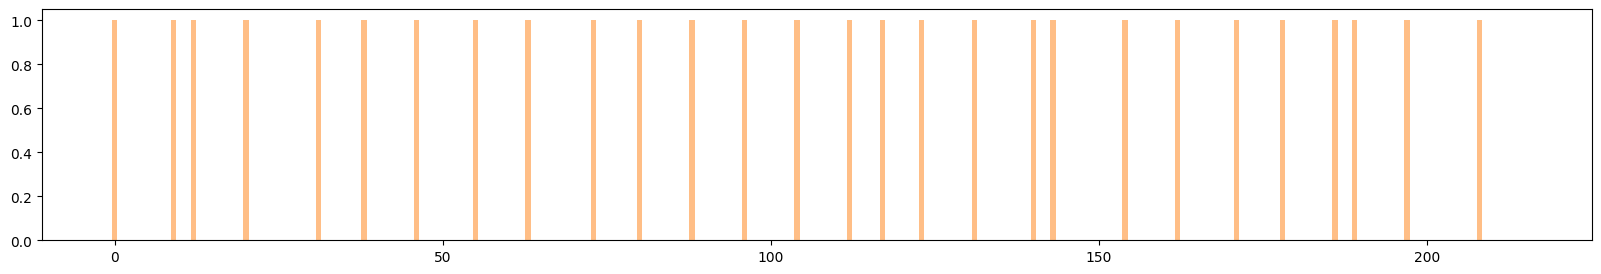

In [404]:
with torch.no_grad():
    prob = model(graph)
plt.figure(figsize=(20, 3))
plt.bar(np.arange(len(prob)), torch.sigmoid(prob[:, 0]))
plt.bar(np.arange(len(prob)), target[:, 0], alpha=0.5);

In [401]:
with torch.no_grad():
    prob = model(graph)
    v, u = model.dec.sample(graph, prob)
u = graph.ndata['operation_index']['o'][u]
gamma_shape = (problem['n_operations'], problem['n_tasks'], problem['n_cities'])
gamma = np.zeros(gamma_shape)
for i in range(len(u)):
    operation, task, city = u[i, 1], u[i, 0], v[i]
    gamma[operation, task, city] = 1
objvalue(problem, gamma, construct_delta(problem, gamma))

8624.25257769241